In [ ]:
#Load box (Points)

import pandas as pd

df_point = pd.read_csv("access_attributes.csv")

return df_point

   Attribute ID Label Type  Street ID  OSM Street ID Neighborhood Name  \
0     113759394   CurbRamp      14809       98239825     Harbor Island   
1     113759395   CurbRamp      14826       98239858     Harbor Island   
2     113759396   CurbRamp      14809       98239825     Harbor Island   
3     113759397   CurbRamp      14809       98239825     Harbor Island   
4     113759398   CurbRamp      14826       98239858     Harbor Island   

   Attribute Latitude  Attribute Longitude Avg Image Capture Date  \
0           47.572360          -122.352356  2017-08-31 17:00:00.0   
1           47.572952          -122.354095  2017-08-31 17:00:00.0   
2           47.572840          -122.352940  2017-08-31 17:00:00.0   
3           47.572910          -122.353020  2016-01-15 16:00:00.0   
4           47.574500          -122.355390  2017-08-31 17:00:00.0   

             Avg Label Date  Severity  Temporary  Agree Count  Disagree Count  \
0   2019-04-21 17:58:33.914       2.0      False           

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_24264\1050032615.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_point_filtered["Label Type"] = df_point_filtered["Label Type"].fillna("Other")
c:\Users\Gustavo\miniforge3\envs\utci\lib\site-packages\pandas\core\dtypes\cast.py:131: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<Axes: >

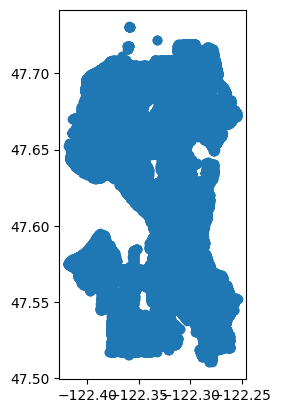

In [ ]:
# Data cleaning (Points)

# Widgets: filter points according to the problem type (LabelType) ['CurbRamp' 'NoSidewalk' 'SurfaceProblem' 'Obstacle' 'Occlusion' 'Other', 'NoCurbRamp' 'Crosswalk' 'Signal']

# Columns to keep:
#  - Label Type
#  - Attribute Latitude
#  - Attribute Longitude 
#  - Agree count
#  - Disagree count
#  - Unsure count

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

df_point = arg

columns_to_keep = ["Label Type", "Attribute Latitude", "Attribute Longitude", "Agree Count", "Disagree Count", "Unsure Count"]
df_point_filtered = df_point[columns_to_keep]

df_point_filtered["Label Type"] = df_point_filtered["Label Type"].fillna("Other")
df_point_filtered = df_point_filtered.dropna(subset=["Attribute Latitude"])
df_point_filtered = df_point_filtered.dropna(subset=["Attribute Longitude"])
df_point_filtered["Agree Count"] = df_point_filtered["Agree Count"].fillna(0)
df_point_filtered["Disagree Count"] = df_point_filtered["Disagree Count"].fillna(0)
df_point_filtered["Unsure Count"] = df_point_filtered["Unsure Count"].fillna(0)

df_point_filtered = df_point_filtered.rename(columns={"Label Type": "label"})
df_point_filtered = df_point_filtered.rename(columns={"Attribute Latitude": "latitude"})
df_point_filtered = df_point_filtered.rename(columns={"Attribute Longitude": "longitude"})
df_point_filtered = df_point_filtered.rename(columns={"Agree Count": "agree"})
df_point_filtered = df_point_filtered.rename(columns={"Disagree Count": "disagree"})
df_point_filtered = df_point_filtered.rename(columns={"Unsure Count": "unsure"})

df_point_filtered["geometry"] = df_point_filtered.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

gdf_point = gpd.GeoDataFrame(df_point_filtered, geometry="geometry", crs="EPSG:4326")

return gdf_point

In [ ]:
# Computation Analysis - Uncertainty score (Points)

gdf_point = arg.set_crs(4326)
gdf_point = gdf_point.to_crs(3395)

gdf_point["total_votes"] = gdf_point["agree"] + gdf_point["disagree"] + gdf_point["unsure"]

gdf_point['total_votes'] = gdf_point['total_votes'].replace(0, 1)

gdf_point["uncertainty"] = (abs(gdf_point["disagree"] - gdf_point["agree"]) + gdf_point["unsure"]) / gdf_point["total_votes"]

gdf_point = gdf_point[["uncertainty", "geometry"]]

gdf_point.metadata = {
 'name': 'ponctual'
}

return gdf_point

In [ ]:
# Data pool (connected to gdf_point)

In [ ]:
# Load box (Neighborhood)

import geopandas as gpd

gdf_neighborhood = gpd.read_file("access_score_neighborhood.geojson")[["coverage", "avg_attribute_count", "geometry"]]

return gdf_neighborhood

In [ ]:
# Data cleaning (Neighborhood)

# Columns to keep:
#  - coverage
#  - CurbRamp
#  - NoCurbRamp
#  - Obstacle
#  - SurfaceProblem

import geopandas as gpd

gdf_neighborhood = arg

gdf_neighborhood = gdf_neighborhood.join(pd.json_normalize(gdf_neighborhood["avg_attribute_count"])).drop(columns=["avg_attribute_count"])

# columns_to_keep = ["coverage", "CurbRamp", "NoCurbRamp", "Obstacle", "SurfaceProblem", "geometry"]
# gdf_neighborhood = gdf_neighborhood[columns_to_keep]

gdf_neighborhood = gdf_neighborhood.dropna(subset=["coverage"])
gdf_neighborhood = gdf_neighborhood.dropna(subset=["geometry"])
gdf_neighborhood["CurbRamp"] = gdf_neighborhood["CurbRamp"].fillna(0)
gdf_neighborhood["NoCurbRamp"] = gdf_neighborhood["NoCurbRamp"].fillna(0)
gdf_neighborhood["Obstacle"] = gdf_neighborhood["Obstacle"].fillna(0)
gdf_neighborhood["SurfaceProblem"] = gdf_neighborhood["SurfaceProblem"].fillna(0)

return gdf_neighborhood

In [ ]:
# Computation Analysis - Acessibility score (Neighborhood)

# Widget: to change w_noCurb, w_obstacle, w_surfaceProblem, w_curb

# This accessibility is relative to other neighborhoods

import numpy as np

gdf_neighborhood = arg.set_crs(4326)
gdf_neighborhood = gdf_neighborhood.to_crs(3395)

w_noCurb = 1
w_obstacle = 1
w_surfaceProblem = 1
w_curb = 1

numerator = (w_noCurb * gdf_neighborhood["NoCurbRamp"] + 
             w_obstacle * gdf_neighborhood["Obstacle"] + 
             w_surfaceProblem * gdf_neighborhood["SurfaceProblem"])

denominator = w_curb * gdf_neighborhood["CurbRamp"]

gdf_neighborhood["accessibility"] = np.where(
    denominator == 0, 
    0, 
    numerator / denominator
)

# gdf_neighborhood["accessibility"] = (w_noCurb * gdf_neighborhood["NoCurbRamp"] + w_obstacle * gdf_neighborhood["Obstacle"] + w_surfaceProblem * gdf_neighborhood["SurfaceProblem"]) / (w_curb * gdf_neighborhood["CurbRamp"])

min_val = gdf_neighborhood["accessibility"].min()
max_val = gdf_neighborhood["accessibility"].max()

denominator = max_val - min_val

if denominator == 0:
    gdf_neighborhood["accessibility"] = 0  # Set a default value
else:
    gdf_neighborhood["accessibility"] = (gdf_neighborhood["accessibility"] - min_val) / denominator


# gdf_neighborhood["accessibility"] = (gdf_neighborhood["accessibility"] - gdf_neighborhood["accessibility"].min()) / (gdf_neighborhood["accessibility"].max() - gdf_neighborhood["accessibility"].min())

gdf_neighborhood = gdf_neighborhood[["geometry", "accessibility"]]

gdf_neighborhood.metadata = {
 'name': 'neighborhood'
}

return gdf_neighborhood
    

In [ ]:

# Data pool (connected to gdf_neighborhood)

In [ ]:
# UTK (connected to gdf_neighborhood)

In [ ]:
# Merge Flow of uncertainty score (points) and acessiblity score (neighborhood)

In [ ]:
# Data tranformation (connect to previous Merge Flow)

# Group point uncertainty score into neighborhood

import geopandas as gpd

gdf_point = arg[0].set_crs(3395)
gdf_neighborhood = arg[1].set_crs(3395)

gdf_point = gdf_point.to_crs(gdf_neighborhood.crs)

gdf_neighborhood["neighborhood_id"] = gdf_neighborhood.index 

gdf_joined = gpd.sjoin(gdf_point, gdf_neighborhood, predicate="within")

df_aggregated = gdf_joined.groupby("neighborhood_id")["uncertainty"].mean().reset_index()

gdf_neighborhood_aggregated = gdf_neighborhood.merge(df_aggregated, on="neighborhood_id", how="left")

gdf_neighborhood_aggregated["uncertainty"] = gdf_neighborhood_aggregated["uncertainty"].fillna(0)

gdf_neighborhood_aggregated = gdf_neighborhood_aggregated[["geometry", "uncertainty"]]

gdf_neighborhood_aggregated.metadata = {
 'name': 'neighborhood'
}

return gdf_neighborhood_aggregated


In [ ]:
# UTK (connected to gdf_neighborhood_aggregated) 

In [ ]:
# Data load (streets)

import geopandas as gpd

gdf_streets = gpd.read_file("access_score_streets.geojson")[["attribute_count", "geometry"]]

return gdf_streets

c:\Users\gugum\miniforge3\envs\curio-sandbox-frontend\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


Index(['street_edge_id', 'osm_id', 'neighborhood_id', 'score', 'audit_count',
       'avg_image_capture_date', 'avg_label_date', 'significance',
       'attribute_count', 'geometry'],
      dtype='object')


c:\Users\gugum\miniforge3\envs\curio-sandbox-frontend\lib\site-packages\geopandas\io\file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\gugum\miniforge3\envs\curio-sandbox-frontend\lib\site-packages\geopandas\io\file.py:387: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore", utc=True)
c:\Users\gugum\miniforge3\envs\curio-sandbox-frontend\lib\site-packages\geopandas\io\file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\gugum\miniforge3\envs\curio-sandbox-frontend\lib\site-

In [ ]:
# Data cleaning (streets)

import geopandas as gpd

gdf_streets = arg

gdf_streets = gdf_streets.join(pd.json_normalize(gdf_streets["attribute_count"])).drop(columns=["attribute_count"])

gdf_streets = gdf_streets.dropna(subset=["geometry"])
gdf_streets["CurbRamp"] = gdf_streets["CurbRamp"].fillna(0)
gdf_streets["NoCurbRamp"] = gdf_streets["NoCurbRamp"].fillna(0)
gdf_streets["Obstacle"] = gdf_streets["Obstacle"].fillna(0)
gdf_streets["SurfaceProblem"] = gdf_streets["SurfaceProblem"].fillna(0)

return gdf_streets

In [ ]:
# Computation Analysis - Acessibility score (Streets)

import numpy as np

gdf_streets = arg.set_crs(4326)
gdf_streets = gdf_streets.to_crs(3395)

w_noCurb = 1
w_obstacle = 1
w_surfaceProblem = 1
w_curb = 1

numerator = (w_noCurb * gdf_streets["NoCurbRamp"] + 
             w_obstacle * gdf_streets["Obstacle"] + 
             w_surfaceProblem * gdf_streets["SurfaceProblem"])

denominator = w_curb * gdf_streets["CurbRamp"]

gdf_streets["accessibility"] = np.where(
    denominator == 0, 
    0, 
    numerator / denominator
)

# gdf_streets["accessibility"] = (w_noCurb * gdf_streets["NoCurbRamp"] + w_obstacle * gdf_streets["Obstacle"] + w_surfaceProblem * gdf_streets["SurfaceProblem"]) / (w_curb * gdf_streets["CurbRamp"])

min_val = gdf_streets["accessibility"].min()
max_val = gdf_streets["accessibility"].max()

denominator = max_val - min_val

if denominator == 0:
    gdf_streets["accessibility"] = 0  # Set a default value
else:
    gdf_streets["accessibility"] = (gdf_streets["accessibility"] - min_val) / denominator


# gdf_streets["accessibility"] = (gdf_streets["accessibility"] - gdf_streets["accessibility"].min()) / (gdf_streets["accessibility"].max() - gdf_streets["accessibility"].min())

gdf_streets = gdf_streets[["geometry", "accessibility"]]

gdf_streets.metadata = {
 'name': 'street'
}

return gdf_streets

In [ ]:
# Data transformation, creating a buffer around the streets

import geopandas as gpd

gdf_streets = arg.set_crs(3395)

gdf_streets = gdf_streets.to_crs(epsg=3857)  # Web Mercator (meters)

gdf_polygons = gdf_streets.copy()
gdf_polygons["geometry"] = gdf_polygons.geometry.buffer(5)

gdf_polygons = gdf_polygons.to_crs(epsg=3395)  # WGS84 (lat/lon)

gdf_polygons.metadata = {
 'name': 'street'
}

return gdf_polygons

In [ ]:
# UTK (connected to gdf_streets)

In [ ]:
# Data pool

In [ ]:
# Merge Flow of uncertainty score (points) and acessiblity score (street)

In [ ]:
# Data tranformation (connect to previous Merge Flow)

import geopandas as gpd
from shapely.ops import nearest_points

gdf_points = arg[0].set_crs(3395)
gdf_streets = arg[1].set_crs(3395)

gdf_streets = gdf_streets.sjoin_nearest(gdf_points[['geometry', 'uncertainty']], how="left", distance_col="distance")

gdf_streets = gdf_streets[["geometry", "uncertainty"]]

# def find_nearest_linestring(point, lines_gdf):
#     return lines_gdf.geometry.iloc[lines_gdf.geometry.distance(point).idxmin()]

# # Associate each point with its nearest LineString
# gdf_points['nearest_line'] = gdf_points.geometry.apply(lambda p: find_nearest_linestring(p, gdf_streets))

# uncertainty_avg = gdf_points.groupby('nearest_line')['uncertainty'].mean()

# gdf_streets['uncertainty'] = gdf_streets.geometry.map(lambda line: uncertainty_avg.get(line, 0))

gdf_streets.metadata = {
 'name': 'street'
}

return gdf_streets

In [ ]:
# UTK (connected to gdf_streets)

- Ask LLM to filter by a specific neighborhood
- Add a barchart that shows accessibility by neighborhood and you can hover and get the highlight on the map
- Add street network